In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tqdm #provides a fast, extensible progress bar for loops in Python. It displays real-time progress, estimated time remaining, and loop iteration speed
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
import os

In [4]:
input_path = []
label = []

base_path = "/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train"

for class_name in os.listdir(base_path):
    for path in os.listdir(os.path.join(base_path,class_name)):
        
        if(class_name == 'NORMAL'):
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join(base_path, class_name ,path))



In [5]:
df=pd.DataFrame()
df['image']=input_path
df['label']=label
df=df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,image,label
0,/kaggle/input/pediatric-pneumonia-chest-xray/P...,1
1,/kaggle/input/pediatric-pneumonia-chest-xray/P...,0
2,/kaggle/input/pediatric-pneumonia-chest-xray/P...,1
3,/kaggle/input/pediatric-pneumonia-chest-xray/P...,1
4,/kaggle/input/pediatric-pneumonia-chest-xray/P...,1


In [7]:
df.shape

(5232, 2)

<Axes: xlabel='label', ylabel='count'>

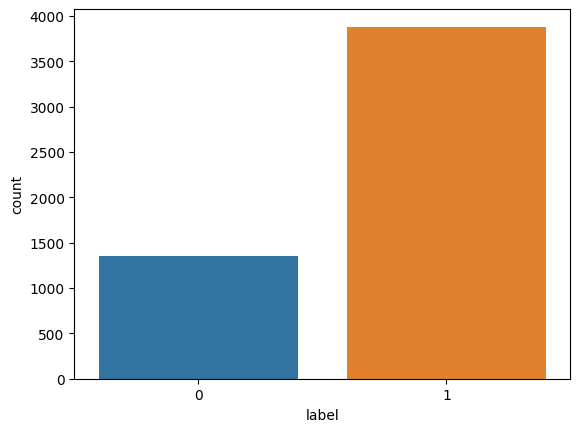

In [8]:
sns.countplot(x=df['label'])

In [9]:
input_path_test = []
label_test = []

base_path_test = "/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test"

for class_name in os.listdir(base_path_test):
    for path_test in os.listdir(os.path.join(base_path_test,class_name)):
        
        if(class_name == 'NORMAL'):
            label_test.append(0)
        else:
            label_test.append(1)
        input_path_test.append(os.path.join(base_path_test, class_name ,path_test))


In [10]:
df_test=pd.DataFrame()
df_test['image_test']=input_path_test
df_test['label_test']=label_test
df_test=df_test.sample(frac=1).reset_index(drop=True)

In [12]:
# Rename columns in df_test to match df
df_test = df_test.rename(columns={'image_test': 'image', 'label_test': 'label'})

# Combine both DataFrames
df_combined = pd.concat([df, df_test], axis=0, ignore_index=True)

# Shuffle if you want
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

print(df_combined.head())


                                               image  label
0  /kaggle/input/pediatric-pneumonia-chest-xray/P...      1
1  /kaggle/input/pediatric-pneumonia-chest-xray/P...      1
2  /kaggle/input/pediatric-pneumonia-chest-xray/P...      1
3  /kaggle/input/pediatric-pneumonia-chest-xray/P...      1
4  /kaggle/input/pediatric-pneumonia-chest-xray/P...      1


In [13]:
df_combined.shape

(5856, 2)

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
print("done")

done


In [21]:
df_combined['label'] = df_combined['label'].astype('str')
print("done")

done


In [22]:
from sklearn.model_selection import train_test_split

# First split
train, temp = train_test_split(df_combined, test_size=0.2, random_state=42)

# Split temp into validation and test
val, test = train_test_split(temp, test_size=0.4, random_state=42)

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")


Train size: 4684
Validation size: 703
Test size: 469


In [23]:
df_combined['label'] = df_combined['label'].astype('str')

<Axes: xlabel='label', ylabel='count'>

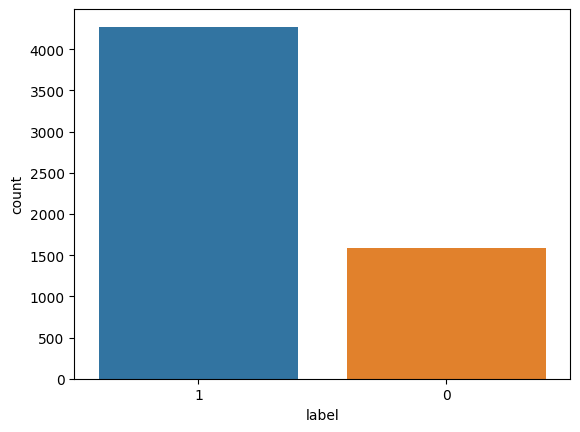

In [24]:

sns.countplot(x=df_combined['label'])


In [20]:
df_combined['label'] = df_combined['label'].astype('str')
print("done")

done


In [ ]:
type(train['label'])

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalization for images
    zoom_range = 0.2,
    horizontal_flip = False,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)


train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'image',
    y_col = 'label',
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'binary',
    validate_filenames = False
)

val_iterator = val_generator.flow_from_dataframe(
    val,
    x_col = 'image',
    y_col = 'label',
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'binary',
    validate_filenames = False
)


Found 4684 non-validated image filenames belonging to 2 classes.
Found 703 non-validated image filenames belonging to 2 classes.


In [26]:
print(train_iterator.samples)
print(val_iterator.samples)

4684
703


In [27]:
from sklearn.utils import class_weight
import numpy as np

# 1. Compute class weights from your train_df labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.8616852146263911, 1: 0.6835960303561004}


In [29]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LayerNormalization


# Load Xception with pretrained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for i, layer in enumerate(base_model.layers):
    if i >= len(base_model.layers) - 25:
        layer.trainable = True  # Unfreeze last 25 layers
    else:
        layer.trainable = False  # Freeze all other layers


# Now build your final model
model = Sequential()

model.add(base_model)  # pretrained convolution base
model.add(GlobalAveragePooling2D())  # reduce spatial dimensions

# Your original dense layers (you can keep or tweak these)
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
model.add(Dropout(0.25))


model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
model.add(Dropout(0.25))

model.add(Dense(8, activation='relu',kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

print("Transfer learning model ready.")


Transfer learning model ready.


In [30]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'],)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 32)                  │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 8)                   │              16 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,134,825 (80.62 MB)

 Trainable params: 8,675,705 (33.10 MB)

 Non-trainable params: 12,459,120 (47.53 MB)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=0,
    min_lr=1e-6
)


In [33]:
history = model.fit(train_iterator, epochs = 50, validation_data = val_iterator,class_weight=class_weight_dict, callbacks=[lr_callback])

Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 140s 239ms/step - accuracy: 0.7309 - loss: 1.0514 - val_accuracy: 0.9004 - val_loss: 0.7014 - learning_rate: 1.0000e-04
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 98s 167ms/step - accuracy: 0.8705 - loss: 0.7586 - val_accuracy: 0.8919 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 99s 168ms/step - accuracy: 0.9004 - loss: 0.6642 - val_accuracy: 0.9161 - val_loss: 0.5892 - learning_rate: 1.0000e-04
Epoch 4/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 98s 167ms/step - accuracy: 0.9354 - loss: 0.5655 - val_accuracy: 0.9275 - val_loss: 0.5626 - learning_rate: 1.0000e-04
Epoch 5/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 98s 168ms/step - accuracy: 0.9508 - loss: 0.5191 - val_accuracy: 0.9459 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 6/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 98s 168ms/step - accuracy: 0.9341 - loss: 0.5303 - val_accuracy: 0.9303 - val_loss: 0.5042 - learning_rate: 1.0000e-04
Epoch 7/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 99s 1

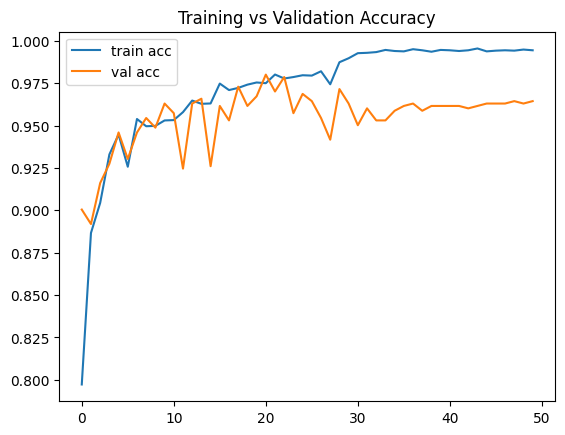

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [35]:
test_generator = ImageDataGenerator(rescale=1./255)

test_iterator = test_generator.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False,  # Important for evaluation and predictions
    validate_filenames=False
)


Found 469 non-validated image filenames belonging to 2 classes.


In [44]:
results = model.evaluate(test_iterator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9592 - loss: 0.2353
Test Loss: 0.2528406083583832
Test Accuracy: 0.9573560953140259


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


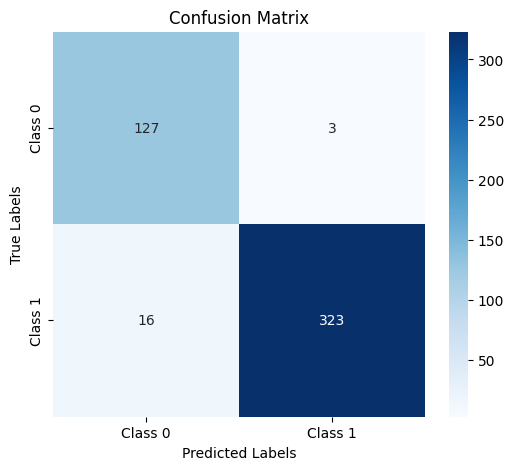

In [40]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Predict on test data
y_pred_probs = model.predict(test_iterator)
y_pred = (y_pred_probs > 0.3).astype(int).flatten()  # for binary classification

# Step 2: Get true labels
y_true = test_iterator.classes

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [43]:
from sklearn.metrics import f1_score, recall_score, precision_score


# Step 3: Calculate scores
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

# Step 4: Print results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.99079754601227
Recall: 0.9528023598820059
F1 Score: 0.9714285714285714
